## Imports & data


In [3]:
!pip install -q sentence-transformers

In [4]:
!pip install pickle5 -q

In [5]:
#canonical
import pandas as pd
import numpy as np 

#words/sentences  preprocessing
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

from tensorflow import GradientTape
import tensorflow as tf 

from IPython.display import HTML,display


#modeling
from tensorflow.keras import models,layers

#google import
from google.colab import auth
from google.colab import drive
import pickle5 as pickle

In [6]:
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_loss_metrics(history, title=None):
    """
    used in DL to plot accuracy and metrics
    must be passed the history of the fitted model
    """
    # -- Retrieve metrics used
    metrics = []
    val_metrics = []

    for m in history.history.keys():
        if m.startswith('val_'):
            val_metrics.append(m)
        else:
            metrics.append(m)

    if len(metrics) % 2 != 0:
        row = len(metrics) // 2 + 1

    if len(metrics) % 2 == 0:
        row = len(metrics) // 2

    fig,axs = plt.subplots(row,2,figsize=(13, 4 * row))

    for m,ax in zip(metrics,axs.flat):
        ax.plot(history.history[m])
        ax.plot(history.history[f'val_{m}'])
        ax.set_title(f'Model {m}')
        ax.set_ylabel(f'{m}')
        ax.set_xlabel('Epoch')
        ax.legend(['Train', 'Test'], loc='best')
        ax.grid(axis="x", linewidth=0.5)
        ax.grid(axis="y", linewidth=0.5)

    if len(metrics) % 2 != 0:
        fig.delaxes[axs.flat[-1]]

    if title:
        fig.suptitle(title)

    pass

In [8]:
#loading embedding
with open('/content/drive/MyDrive/FOBOKILLER/data/review_embed.pkl','rb') as file:
  dataset = pickle.load(file)

In [7]:
#dataset=pd.read_csv('/content/drive/MyDrive/FOBOKILLER/data/scrapping_cleaned_sentences.csv',index_col=0)

In [8]:
dataset[dataset['rate']==5].shape

(27903, 4)

In [9]:
# Creating balanced dataset
df1=dataset[dataset['rate']==1].sample(5000,replace=True)
df2=dataset[dataset['rate']==2].sample(5000,replace=True)
df3=dataset[dataset['rate']==3].sample(5000,replace=True)
df4=dataset[dataset['rate']==4].sample(5000)
df5=dataset[dataset['rate']==5].sample(5000)

dataset_balanced=pd.concat([df1,df2,df3,df4,df5])
df1.shape,df2.shape,df3.shape,df4.shape,df5.shape,dataset_balanced.shape

((5000, 4), (5000, 4), (5000, 4), (5000, 4), (5000, 4), (25000, 4))

In [10]:
#X y
X=np.array(dataset_balanced['embedding'])
y=dataset_balanced['rate']

    ### BINARY ###
y_binary = np.where(y <4,0,1)
#split train test BINARY
X_train,X_test,y_train,y_test = train_test_split(X,y_binary,test_size=.3)

    ### CATEGORICAL ###
#y_cat=to_categorical(y)
#X_cat_train,X_cat_test,y_cat_train,y_cat_test = train_test_split(X,y_cat,test_size=.3)

# Pad the training and test embedded sentences
X_train_pad = pad_sequences(X_train, dtype='float32', padding='post', maxlen=30)
X_test_pad = pad_sequences(X_test, dtype='float32', padding='post', maxlen=30)



In [ ]:
X_test_pad.shape

## Dump review padded

In [13]:
with open('/content/drive/MyDrive/FOBOKILLER/data/review_padded_train.pkl','wb') as file:
  pickle.dump(X_train_pad,file)

In [14]:
with open('/content/drive/MyDrive/FOBOKILLER/data/review_padded_test.pkl','wb') as file:
  pickle.dump(X_test_pad,file)

In [ ]:
with open('/content/drive/MyDrive/FOBOKILLER/data/review_padded_train.pkl','rb') as file:
  pickle.dump(X_train_pad,file)

In [11]:
def binary_model():
  model=models.Sequential()
  model.add(layers.Conv1D(300,3,padding='same',input_shape=(30,768)))
  model.add(layers.MaxPool1D(2))
  model.add(layers.Conv1D(300,3,padding='same'))
  model.add(layers.MaxPool1D(2))
  model.add(layers.Flatten())
  model.add(layers.Dense(130,activation='relu'))
  model.add(layers.Dense(1,activation='sigmoid'))
  
  model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

  return model

In [12]:
model=binary_model()
#model.summary()

Epoch 1/50
438/438 [==============================] - 30s 18ms/step - loss: 0.2786 - accuracy: 0.8869 - val_loss: 0.2611 - val_accuracy: 0.8963
Epoch 2/50
438/438 [==============================] - 6s 13ms/step - loss: 0.2084 - accuracy: 0.9143 - val_loss: 0.2596 - val_accuracy: 0.9017
Epoch 3/50
438/438 [==============================] - 6s 13ms/step - loss: 0.1559 - accuracy: 0.9368 - val_loss: 0.2407 - val_accuracy: 0.9057
Epoch 4/50
438/438 [==============================] - 6s 13ms/step - loss: 0.1023 - accuracy: 0.9601 - val_loss: 0.3413 - val_accuracy: 0.8994
Epoch 5/50
438/438 [==============================] - 6s 13ms/step - loss: 0.0557 - accuracy: 0.9785 - val_loss: 0.4073 - val_accuracy: 0.9031


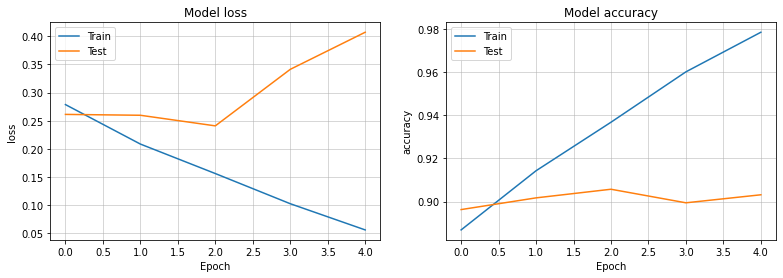

In [13]:
es=EarlyStopping(patience=2,restore_best_weights=True)
history = model.fit(X_train_pad,y_train,validation_split=.2,batch_size=32,epochs=50,callbacks=[es])
plot_loss_metrics(history)

In [14]:
import joblib

In [16]:
model.save('/content/drive/MyDrive/FOBOKILLER/model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/FOBOKILLER/model/assets


In [17]:
def heatmap_sentences(review_sentences,review_embedded,model,layer):
  #padding
  review_embedded=pad_sequences([review_embedded], dtype='float32', padding='post', maxlen=30)
  # predict for X_test_pad[1]
  preds = model.predict(review_embedded)  
  with tf.GradientTape() as tape:
    class_idx = np.argmax(preds[0])
    last_conv_layer = model.get_layer(layer)
    iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
    model_out, last_conv_layer = iterate(review_embedded)
    class_out = model_out[:, class_idx]
    grads = tape.gradient(class_out, last_conv_layer)
    #pooled_grads = K.mean(grads, axis=(0, 1, 2))
    pooled_grads = tf.reduce_mean(grads)
  
  heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)  
  
  html=""
  for j,i in enumerate(review_sentences):
    html += f"<span style='background-color:rgba(0,{heatmap[0][j]*255},0,0.6)'>{i} </span>"

  return heatmap,html

In [18]:
test=dataset.loc[2436]
test

review_clean        after visiting the tour eiffel, we came here t...
review_sentences    [after visiting the tour eiffel, we came here ...
embedding           [[-0.020146683, 0.03199018, -0.012785325, 0.01...
rate                                                                5
Name: 2436, dtype: object

In [ ]:
array=np.array(test['embedding'])
array
b=np.array([np.vstack([array,np.zeros((0,768))])])

In [ ]:
pad_sequences([array], dtype='float32', padding='post', maxlen=30).shape

(1, 30, 768)

In [19]:
h,html=heatmap_sentences(test['review_sentences'],test['embedding'],model,'conv1d')

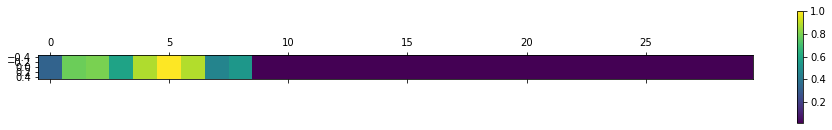

In [41]:
plt.matshow(h)
plt.colorbar()

In [20]:
HTML(html)

In [43]:
dataset.head()

,review_clean,review_sentences,embedding,rate
0,"!!! a theif working amongst you!!! myself, my ...","[ a theif working amongst you, myself, my sis...","[[0.045603834, -0.017338777, 0.0012167644, 0.0...",1.0
1,"""""""""avoid at all costs"""""""""""" this was an absol...","[""""""""avoid at all costs"""""""""""" this was an abso...","[[0.019589972, 0.048924193, -0.015198772, -0.0...",1.0
2,"""$$$"" food but only at a ""$"" price. will be co...","[""$$$"" food but only at a ""$"" price, will be ...","[[0.016501594, 0.1083755, 0.014006043, -0.0319...",5.0
3,"""a middle finger salute"" well i haven't had ma...","[""a middle finger salute"" well i haven't had m...","[[0.019542666, -0.017905522, 0.0037664298, 0.0...",1.0
4,"""a true disappointment and a waste of money an...","[""a true disappointment and a waste of money a...","[[0.036009785, 0.0029092361, 0.0132899275, 0.0...",1.0


In [21]:
def html_df(df):
  heatmap,html=heatmap_sentences(df['review_sentences'],df['embedding'],model,'conv1d')
  return html

In [34]:
sub_df=dataset.sample(200)
sub_df['html']=sub_df.apply(html_df,axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


IndexError: ignored

In [32]:
sub_df.reset_index(inplace=True,drop=True)

In [33]:
for i in range(100):
  review = sub_df.loc[i,'html']
  rate = sub_df.loc[i,'rate']
  
  review_embedded=pad_sequences([sub_df.loc[i,'embedding']], dtype='float32', padding='post', maxlen=30)
  pred = model.predict(review_embedded)  

  print(f'----- model predict : {pred[0]} ----- real rate : {rate}')
  display(HTML(review))

----- model predict : [0.13183762] ----- real rate : 4.0


----- model predict : [0.99415165] ----- real rate : 4.0


----- model predict : [0.9934797] ----- real rate : 4.0


----- model predict : [0.9914091] ----- real rate : 5.0


----- model predict : [0.00347103] ----- real rate : 3.0


----- model predict : [0.98770267] ----- real rate : 5.0


----- model predict : [0.0001466] ----- real rate : 2.0


----- model predict : [0.9986105] ----- real rate : 5.0


----- model predict : [5.169203e-06] ----- real rate : 1.0


----- model predict : [0.85749614] ----- real rate : 5.0


----- model predict : [0.9990257] ----- real rate : 5.0


----- model predict : [0.98408496] ----- real rate : 5.0


----- model predict : [0.1503336] ----- real rate : 2.0


----- model predict : [0.0007045] ----- real rate : 2.0


----- model predict : [0.8798736] ----- real rate : 4.0


----- model predict : [3.9731088e-07] ----- real rate : 1.0


----- model predict : [0.28663182] ----- real rate : 3.0


----- model predict : [0.99869424] ----- real rate : 4.0


----- model predict : [0.03707924] ----- real rate : 1.0


----- model predict : [0.18761566] ----- real rate : 3.0


----- model predict : [0.5544613] ----- real rate : 5.0


----- model predict : [0.99984825] ----- real rate : 5.0


----- model predict : [0.9999728] ----- real rate : 5.0


----- model predict : [0.9889965] ----- real rate : 4.0


----- model predict : [0.9999244] ----- real rate : 5.0


----- model predict : [3.1704587e-07] ----- real rate : 1.0


----- model predict : [0.99724716] ----- real rate : 5.0


----- model predict : [0.99368274] ----- real rate : 5.0


----- model predict : [0.811572] ----- real rate : 5.0


----- model predict : [0.2179159] ----- real rate : 5.0


----- model predict : [0.84481674] ----- real rate : 5.0


----- model predict : [0.15609495] ----- real rate : 5.0


----- model predict : [0.9993315] ----- real rate : 5.0


----- model predict : [0.99997187] ----- real rate : 5.0


----- model predict : [0.94903195] ----- real rate : 4.0


----- model predict : [0.99986994] ----- real rate : 5.0


----- model predict : [0.9956262] ----- real rate : 5.0


----- model predict : [0.99043477] ----- real rate : 5.0


----- model predict : [0.02507083] ----- real rate : 1.0


----- model predict : [0.9501967] ----- real rate : 5.0


----- model predict : [0.87692726] ----- real rate : 4.0


----- model predict : [0.05264979] ----- real rate : 4.0


----- model predict : [0.99977726] ----- real rate : 4.0


----- model predict : [0.72473943] ----- real rate : 4.0


----- model predict : [0.79996413] ----- real rate : 4.0


----- model predict : [0.9678737] ----- real rate : 4.0


----- model predict : [0.08739373] ----- real rate : 3.0


----- model predict : [0.07848176] ----- real rate : 2.0


----- model predict : [0.99937123] ----- real rate : 5.0


----- model predict : [0.9953491] ----- real rate : 5.0


----- model predict : [0.9745875] ----- real rate : 4.0


----- model predict : [0.8918436] ----- real rate : 5.0


----- model predict : [0.44753057] ----- real rate : 4.0


----- model predict : [0.9423342] ----- real rate : 5.0


----- model predict : [0.9998078] ----- real rate : 5.0


----- model predict : [0.9177362] ----- real rate : 4.0


----- model predict : [0.9999033] ----- real rate : 5.0


----- model predict : [0.9981025] ----- real rate : 5.0


----- model predict : [0.66986233] ----- real rate : 3.0


----- model predict : [0.7243617] ----- real rate : 3.0


----- model predict : [0.0011353] ----- real rate : 1.0


----- model predict : [0.9989183] ----- real rate : 5.0


----- model predict : [0.9994361] ----- real rate : 5.0


----- model predict : [0.87436694] ----- real rate : 3.0


----- model predict : [0.19836813] ----- real rate : 5.0


----- model predict : [0.16741322] ----- real rate : 2.0


----- model predict : [0.9731137] ----- real rate : 5.0


----- model predict : [0.08099515] ----- real rate : 1.0


----- model predict : [0.9552985] ----- real rate : 5.0


----- model predict : [0.9984321] ----- real rate : 4.0


----- model predict : [0.9951433] ----- real rate : 5.0


----- model predict : [5.440318e-05] ----- real rate : 3.0


----- model predict : [0.00202956] ----- real rate : 1.0


----- model predict : [0.00021262] ----- real rate : 3.0


----- model predict : [0.00018444] ----- real rate : 1.0


----- model predict : [0.5806228] ----- real rate : 4.0


----- model predict : [0.8281889] ----- real rate : 5.0


----- model predict : [0.8666477] ----- real rate : 4.0


----- model predict : [0.9980095] ----- real rate : 5.0


----- model predict : [0.1731884] ----- real rate : 3.0


----- model predict : [0.64068615] ----- real rate : 5.0


----- model predict : [0.00078173] ----- real rate : 2.0


----- model predict : [0.8820746] ----- real rate : 4.0


----- model predict : [0.9523788] ----- real rate : 4.0


----- model predict : [5.4017528e-05] ----- real rate : 1.0


----- model predict : [3.469697e-05] ----- real rate : 1.0


----- model predict : [0.9973648] ----- real rate : 5.0


----- model predict : [0.00081616] ----- real rate : 3.0


----- model predict : [0.966279] ----- real rate : 5.0


----- model predict : [0.9643292] ----- real rate : 4.0


----- model predict : [0.991642] ----- real rate : 4.0


----- model predict : [0.4867197] ----- real rate : 3.0


----- model predict : [0.99939156] ----- real rate : 5.0


----- model predict : [0.9958727] ----- real rate : 5.0


----- model predict : [0.78610307] ----- real rate : 4.0


----- model predict : [0.00018229] ----- real rate : 2.0


----- model predict : [0.9977289] ----- real rate : 5.0


----- model predict : [0.5048001] ----- real rate : 5.0


----- model predict : [0.89091474] ----- real rate : 5.0


----- model predict : [0.44217342] ----- real rate : 4.0


In [66]:
dataset.head()

,review_clean,review_sentences,embedding,rate
0,"!!! a theif working amongst you!!! myself, my ...","[ a theif working amongst you, myself, my sis...","[[0.045603834, -0.017338777, 0.0012167644, 0.0...",1.0
1,"""""""""avoid at all costs"""""""""""" this was an absol...","[""""""""avoid at all costs"""""""""""" this was an abso...","[[0.019589972, 0.048924193, -0.015198772, -0.0...",1.0
2,"""$$$"" food but only at a ""$"" price. will be co...","[""$$$"" food but only at a ""$"" price, will be ...","[[0.016501594, 0.1083755, 0.014006043, -0.0319...",5.0
3,"""a middle finger salute"" well i haven't had ma...","[""a middle finger salute"" well i haven't had m...","[[0.019542666, -0.017905522, 0.0037664298, 0.0...",1.0
4,"""a true disappointment and a waste of money an...","[""a true disappointment and a waste of money a...","[[0.036009785, 0.0029092361, 0.0132899275, 0.0...",1.0


### MULTICLASS

In [ ]:
def cat_model():
  model=models.Sequential()
  model.add(layers.Conv1D(300,3,padding='same',input_shape=(30,768)))
  model.add(layers.MaxPool1D(2))
  model.add(layers.Conv1D(300,3,padding='same'))
  model.add(layers.MaxPool1D(2))
  model.add(layers.Flatten())
  model.add(layers.Dense(130,activation='relu'))
  model.add(layers.Dense(6,activation='softmax'))
  
  model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

  return model

In [ ]:
cat_model=cat_model()

In [ ]:
# Pad the training and test embedded sentences
X_train_pad = pad_sequences(X_cat_train, dtype='float32', padding='post', maxlen=30)
X_test_pad = pad_sequences(X_cat_test, dtype='float32', padding='post', maxlen=30)

Epoch 1/50
263/263 [==============================] - 5s 16ms/step - loss: 1.0332 - accuracy: 0.5286 - val_loss: 0.9657 - val_accuracy: 0.5714
Epoch 2/50
263/263 [==============================] - 3s 13ms/step - loss: 0.8432 - accuracy: 0.6261 - val_loss: 0.8999 - val_accuracy: 0.6029
Epoch 3/50
263/263 [==============================] - 3s 12ms/step - loss: 0.7036 - accuracy: 0.6930 - val_loss: 1.0315 - val_accuracy: 0.5657
Epoch 4/50
263/263 [==============================] - 3s 13ms/step - loss: 0.5150 - accuracy: 0.7907 - val_loss: 1.1408 - val_accuracy: 0.5690


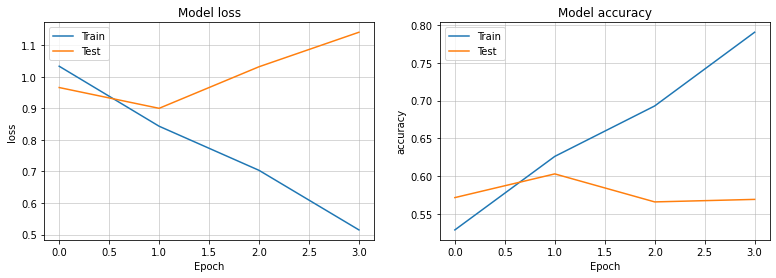

In [ ]:
es=EarlyStopping(patience=2,restore_best_weights=True)
history = cat_model.fit(X_train_pad,y_cat_train,validation_split=.2,batch_size=32,epochs=50,callbacks=[es])
plot_loss_metrics(history)